In [1]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
BORDER_SIZE = 15

In [2]:
def open_imgs(dir_path):
    # Funkcija koja koristi glob za otvaranje na slikite
    """
    :param dir_path:
    :return: list of images
    """
    img_dir = "{}".format(dir_path)  # Enter Directory of all images
    data_path = os.path.join(img_dir, '*g')
    files = glob.glob(data_path)
    data = []
    for f1 in files:
        img = cv2.imread(f1)
        data.append(img)
    return data


In [3]:
def get_leaf_contour(img_leaf):
    # Funkcija koja kako argument prima slika so list, primenuva tehniki za segmentacija i kako rezultat
    # ja vraka konturata na listot vo sodoveten format podrzhan od opencv2.

    """
    :param img_leaf:
    :return: leaf_contour, see open-cv contours
    """

    img_leaf = cv2.copyMakeBorder(
        img_leaf,
        BORDER_SIZE,
        BORDER_SIZE,
        BORDER_SIZE,
        BORDER_SIZE,
        cv2.BORDER_CONSTANT,
        value=(255, 255, 255)
    )
    img_area = (len(img_leaf) * len(img_leaf[0]))  # Converting the BGR image to greyscale
    img_grey = cv2.cvtColor(img_leaf, cv2.COLOR_BGR2GRAY)  # Denoising the greyscale image with median blur
    img_grey = cv2.medianBlur(img_grey, 5)  # Thresholding the denoised greyscale image using OTSU's thresholding
    img_th = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]  # Performing closing
    kernel = np.ones((4, 4), np.uint8)
    closed = cv2.dilate(cv2.erode(img_th, kernel, iterations=1), kernel, iterations=1)  # The result

    # Detekcija i iscrtuvanje na konturite
    leaf_ratio = 1 - (np.count_nonzero(np.array(closed)) / img_area)
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=lambda c: abs(leaf_ratio - (cv2.contourArea(c) / img_area)))

    leaf_contour = contours[0]  # Let the first contour be the leaf
    cv2.drawContours(img_leaf, [leaf_contour], -1, (0, 0, 255), 3)
    return leaf_contour


In [4]:
def map_all_conts(imgs):
    # Funkcija koja vraka recnik so sto sekoja slika e mapirana vo konturata na listot
    contours_dict = {}  # key : IMAGE value: LEAF CONTOUR
    for img in imgs:
        key = get_img_hash(img)
        contours_dict[key] = get_leaf_contour(img)
    return contours_dict
        

In [5]:
def index_hash_imgs(imgs):
    # Recnik za indeksiranje na slika spored nejziniot hash
    # KEY: img_hash, VALUE: np_img
    index_dict = {}
    for img in imgs:
        key = get_img_hash(img)
        index_dict[key] = img
    return index_dict

In [6]:
def query_img(query_cont, db_conts):
    # Funkcija koja pravi query vo bazata so sliki i metchuva konturi
    query_result = {}
    for k,v in db_conts.items():
        query_result[k] = cv2.matchShapes(query_cont, v, cv2.CONTOURS_MATCH_I3,0)
    return query_result

In [7]:
def get_img_hash(img):
    return repr(hash(img.tobytes()))

In [8]:
def display_results(query_result):
    # Funkcija koja gi vraka rezultatite od query-to sortirani od najslicnata do naj ne slicnata slika
    query_result = list(query_result.items())
    query_result = sorted(query_result, key=lambda q: q[1])
    query_result_imgs = [img[0] for img in query_result]  # Sliki
    query_result_sims = [img[1] for img in query_result]  # Slichnosti
    return query_result_imgs

Query Image:


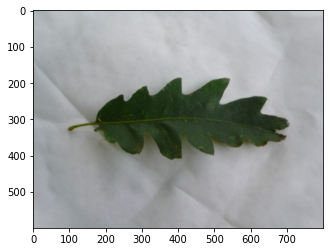

Results (from the most similar to the least similar):


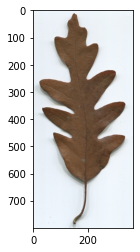

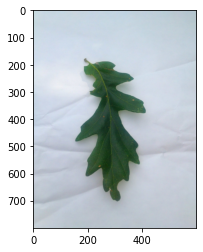

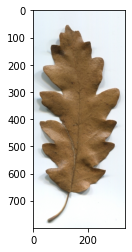

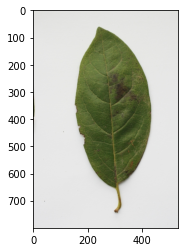

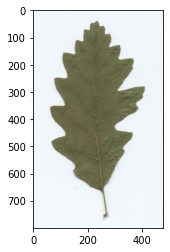

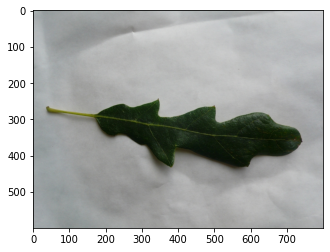

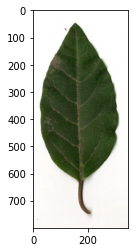

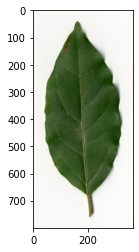

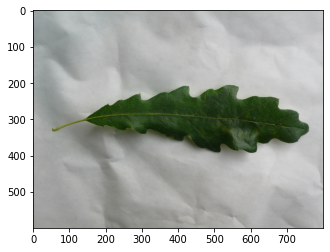

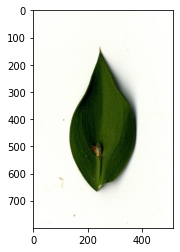

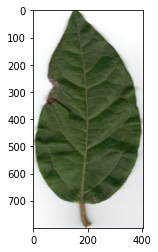

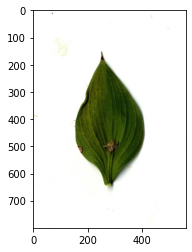

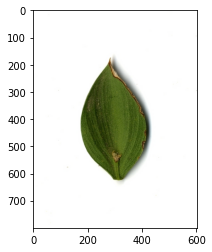

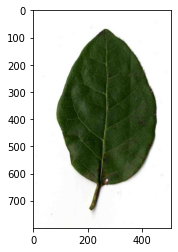

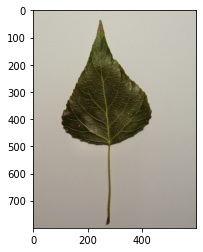

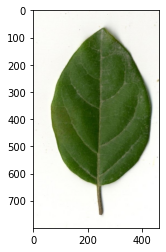

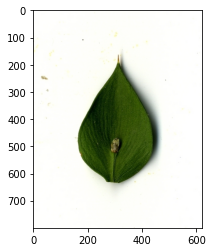

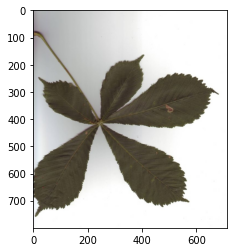

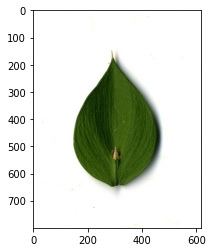

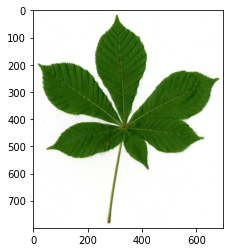

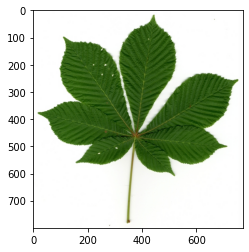

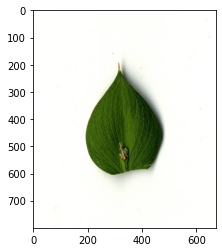

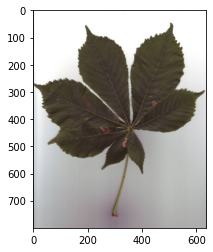

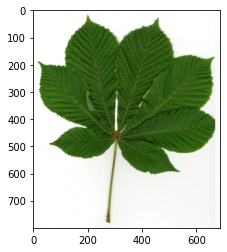

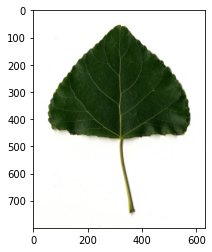

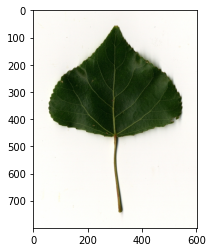

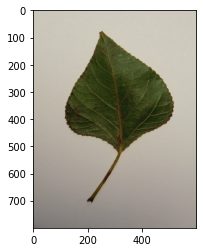

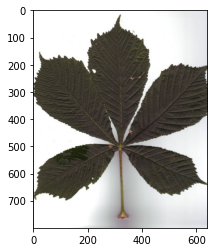

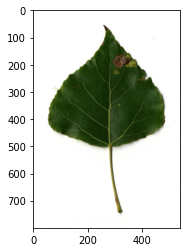

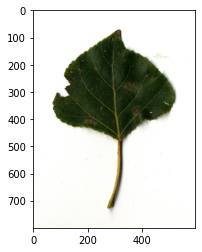

In [9]:
query_imgs = open_imgs('query')
database_imgs = open_imgs('database')
query_conts_dict = map_all_conts(query_imgs)
database_conts_dict = map_all_conts(database_imgs)
index_dict = index_hash_imgs(query_imgs + database_imgs)

QUERY_IMG = query_imgs[5]

query_result = query_img(query_conts_dict[get_img_hash(QUERY_IMG)], database_conts_dict)

print("Query Image:")
plt.figure()
plt.imshow(cv2.cvtColor(QUERY_IMG,cv2.COLOR_BGR2RGB))
plt.show()

display_results  = display_results(query_result)
print("Results (from the most similar to the least similar):")

for img in display_results:
    plt.figure()
    plt.imshow(cv2.cvtColor(index_dict[img],cv2.COLOR_BGR2RGB))
    plt.show()